In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

In [2]:
#find filepath for 'count_data' in each country

%cd /share/costeffectiveness/results
%cd vivarium_conic_lsff/
%cd v1.0_disease_only/
%cd nigeria/
%cd 2020_02_26_16_19_00
%cd count_data
!ls -halt

/ihme/costeffectiveness/results
/ihme/costeffectiveness/results/vivarium_conic_lsff
/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only
/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/nigeria
/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/nigeria/2020_02_26_16_19_00
/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/nigeria/2020_02_26_16_19_00/count_data
total 14M
-rw-r--r-- 1 collijk Domain Users  12K Mar 18 19:40 births_with_ntd.csv
drwxr-xr-x 2 collijk Domain Users 9.0K Mar 18 19:40 .
-rw-r--r-- 1 collijk Domain Users 1.1M Mar 18 19:40 births_with_ntd.hdf
-rw-r--r-- 1 collijk Domain Users 9.5K Mar 18 19:40 births.csv
-rw-r--r-- 1 collijk Domain Users 1.1M Mar 18 19:40 births.hdf
-rw-r--r-- 1 collijk Domain Users 620K Mar 18 19:40 transition_count.csv
-rw-r--r-- 1 collijk Domain Users 1.8M Mar 18 19:40 transition_count.hdf
-rw-r--r-- 1 collijk Domain Users 513K Mar 18 19:40 state_person_time.csv
-rw-r--

In [3]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/ethiopia/2020_02_26_16_15_59/count_data/',
               '/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/india/2020_02_26_16_17_48/count_data/',
               '/ihme/costeffectiveness/results/vivarium_conic_lsff/v1.0_disease_only/nigeria/2020_02_26_16_19_00/count_data/']

locations = ['ethiopia','india','nigeria']

# 1) Model outputs for birth prevalence of ntd

In [4]:
#model results for NEURAL TUBE DEFECTS for birth prevalence

def get_birth_prevalence_ntd_results():
    
    master_data_other = pd.DataFrame()
    
    for i in list(range(len(output_dirs))):
        
    #BIRTHS WITH NTDs 
        births_ntd1 = pd.read_hdf(output_dirs[i] + 'births_with_ntd.hdf')
        births_ntd2 = (births_ntd1.groupby(['input_draw','year'], as_index=False).sum() # collapsed over sex
                  .rename(columns={'value':'births_with_ntd'})) 
        
    #BIRTHS (25 input_draws x 4 age_groups = 100 rows)
        births_1 = pd.read_hdf(output_dirs[i] + 'births.hdf')
        births_2 = (births_1.groupby(['input_draw','year'], as_index=False).sum()
              .rename(columns={'value':'births'})) 
   
    #MERGING deaths + pt + state_pt    
        data_other = births_ntd2.merge(births_2, right_on=['input_draw','year'],
                           left_on=['input_draw','year'])
  
        #calculating measures: csmr, emr, prevalence 
        data_other['ntd_birth_prevalence'] = data_other['births_with_ntd'] / data_other['births'] #equation for csmr
        
        data_other['location'] = locations[i]
        data_other = data_other.groupby(['location'], as_index=False).mean()
        
        
        master_data_other = master_data_other.append(data_other)
    
    master_data_other = (master_data_other.sort_values(by='location')
                     .drop(columns=['input_draw']))
                                 
    return master_data_other

In [5]:
ntdbirthprev_model=get_birth_prevalence_ntd_results()
ntdbirthprev_model.head()

,location,births_with_ntd,births,ntd_birth_prevalence
0,ethiopia,145.032,80410.296,0.001800
0,india,49.360,68380.832,0.000728
0,nigeria,209.032,81497.088,0.002567


# 2) Artifact outputs for ntds

In [11]:
def get_ntd_birthprev_artifact_data():
    master_art_data = pd.DataFrame()
    for i in ['ethiopia','india','nigeria']:
        art = Artifact('/share/costeffectiveness/artifacts/vivarium_conic_lsff/' + i + '.hdf', 
                   filter_terms=['year_start == 2017'])
        
        data = art.load('cause.neural_tube_defects.birth_prevalence')
        data = pd.DataFrame(data.mean(axis=1)).reset_index().rename(columns={0:'value'})
        data['location'] = i.capitalize()
        data = data.groupby(['location'], as_index=False).mean()
        master_art_data = master_art_data.append(data)
    return master_art_data

In [17]:
ntdbirthprev_artifact=get_ntd_birthprev_artifact_data()
ntdbirthprev_artifact.head()

,location,year_start,year_end,value
0,Ethiopia,2017,2018,0.001834
0,India,2017,2018,0.000738
0,Nigeria,2017,2018,0.002609


# 3) Plot model output and artifact 

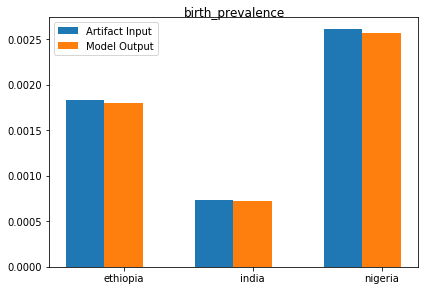

In [50]:
barWidth = 0.3
fig,axs = plt.subplots()
model = ntdbirthprev_model['ntd_birth_prevalence'].dropna()
gbd = ntdbirthprev_artifact['value'].dropna()
a = np.arange(len(model))
b = [x + barWidth for x in a]
plt.bar(a, gbd, width=barWidth)
plt.bar(b, model, width=barWidth)
#axs[0,0].set_title('neural tube defects birth prevalence')
    
plt.setp(axs, xticks=[r + barWidth for r in range(len(model))], 
             xticklabels=np.unique(ntdbirthprev_model['location']))

#ax.set(ylabel='prevalence')
plt.legend(['Artifact Input','Model Output'])
plt.suptitle('birth_prevalence',x=0.55, y=1)
plt.subplots_adjust(right=1.7, top=1.5)
plt.tight_layout()
    

      